In [1]:
## for data
import json
import pandas as pd
import numpy as np
from sklearn import metrics, manifold
## for processing
import re
import nltk
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for w2v
import gensim
import gensim.downloader as gensim_api
## for bert
from transformers import BertTokenizer, BertModel
import transformers

from tqdm.notebook import tqdm
tqdm.pandas()
import torch

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print(device)

C:\Users\Sam's PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
df = pd.read_csv(r'..\data\dataout.csv')

df = df[df["label"].isin(['Male','Female'])][["label","text"]]

df = df.rename(columns={"label":"y", "text":"text"})

df.sample(5)

,y,text
17842,Male,Administrators at Georgetown University releas...
10152,Male,Washington (CNN) The White House can’t get its...
450,Male,Leaked tapes of CNN employees released by Proj...
40091,Female,"COPENHAGEN, Denmark (AP) — A Danish prosecu..."
71,Male,Former Late Show host David Letterman says he ...


In [3]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and   
    #characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [4]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [5]:
df["text_clean"] = df["text"].progress_apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
df.head()

  0%|          | 0/40666 [00:00<?, ?it/s]

,y,text,text_clean
0,Male,WASHINGTON — Congressional Republicans have...,washington congressional republican new fear c...
1,Male,"The NFL needs to get its “priorities in order,...",nfl need get priority order team hire colin ka...
2,Male,"In an in the New York Times, actress Lena Du...",new york time actress lena dunham say presiden...
3,Male,A waitress was fired after retrieving a gun fo...,waitress fired retrieving gun alleged robbery ...
4,Male,WASHINGTON — The White House on Thursday “c...,washington white house thursday counseled kell...


In [6]:
nlp = gensim_api.load("glove-wiki-gigaword-300")

In [7]:
nlp.most_similar(["obama"], topn=3)

[('barack', 0.9254721999168396),
 ('mccain', 0.7590768337249756),
 ('bush', 0.7570988535881042)]

In [8]:
## Function to apply
def get_similar_words(lst_words, top, nlp):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))
## Create Dictionary {category:[keywords]}
dic_clusters = {}
dic_clusters["MALE"] = get_similar_words(["active", "adventurous", "aggressive", "ambition", "assert", "athletic", "autonomous", "boast", "challenge", "champion", "competitive", "decisive", "determination", "strong", "stubborn"]
, top=30, nlp=nlp)
dic_clusters["FEMALE"] = get_similar_words(["affectionate", "childlike", "cheer", "committed", "compassion", "connect", "considerate", "depend", "emotion", "feminine", "gentle"]
, top=30, nlp=nlp)
## print some
for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...", len(v))

MALE :  ['aggressive', 'competitive', 'champion', 'determined', 'desire'] ... 45
FEMALE :  ['affectionate', 'committed', 'depend', 'polite', 'affection'] ... 41


C:\Users\Sam's PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Sam's PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\Sam's PC\AppData\Local\Temp\ipykernel_28480\1070322801.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf = dtf.append(dtf_group)
C:\Users\Sam's PC\AppData\Local\Temp\ipykernel_28480\1070322801.py:16: FutureWarning: The frame.append method is deprecated and will be rem

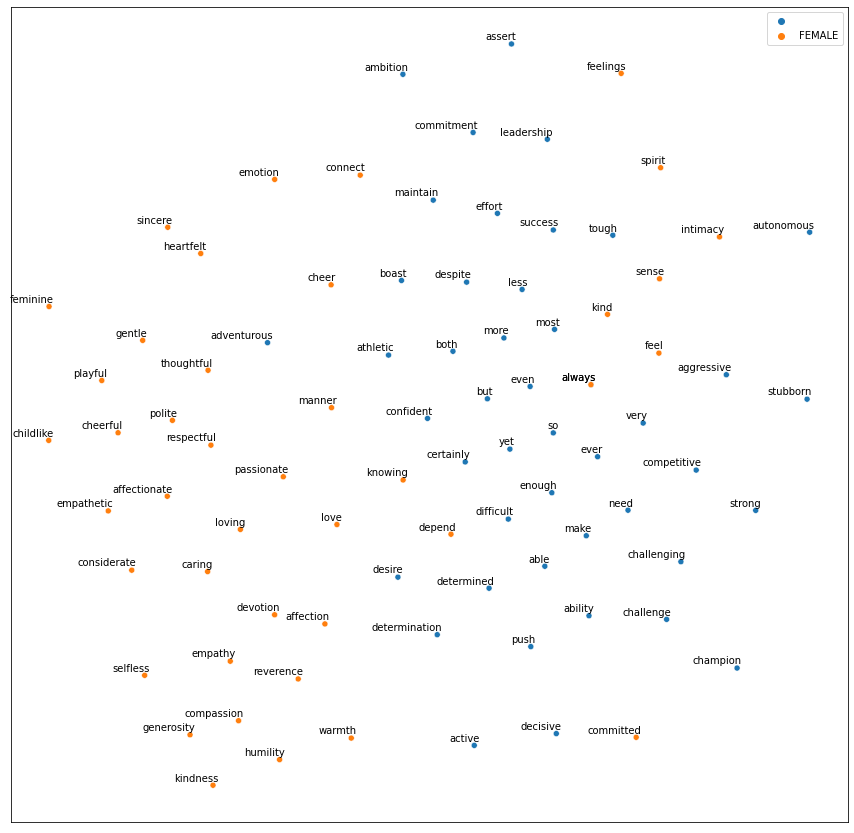

In [9]:
## word embedding
tot_words = [word for v in dic_clusters.values() for word in v]
X = nlp[tot_words]
        
## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(dtf) + len(v)
    dtf_group = pd.DataFrame(X[len(dtf):size], columns=["x","y"], 
                             index=v)
    dtf_group["cluster"] = k
    dtf = dtf.append(dtf_group)
        
## plot
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,15))
sns.scatterplot(data=dtf, x="x", y="y", hue="cluster", ax=ax)
ax.legend().texts[0].set_text(None)
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], 
       yticks=[], yticklabels=[])
for i in range(len(dtf)):
    ax.annotate(dtf.index[i], 
               xy=(dtf["x"].iloc[i],dtf["y"].iloc[i]), 
               xytext=(5,2), textcoords='offset points', 
               ha='right', va='bottom')

In [10]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [11]:
txt = "river bank"
## tokenize
idx = tokenizer.encode(txt)
print("tokens:", tokenizer.convert_ids_to_tokens(idx))
print("ids   :", tokenizer.encode(txt))
## word embedding
idx = np.array(idx)[None,:]
embedding = nlp(idx)
print("shape:", embedding[0][0].shape)
## vector of the second input word
embedding[0][0][2]

tokens: ['[CLS]', 'river', 'bank', '[SEP]']
ids   : [101, 2314, 2924, 102]
shape: (4, 768)


<tf.Tensor: shape=(768,), dtype=float32, numpy=
array([-7.05835894e-02, -6.21527851e-01, -7.02520430e-01, -2.49586910e-01,
        5.77253342e-01,  4.81010735e-01,  2.44046241e-01,  5.12865067e-01,
       -3.52891147e-01, -8.16164017e-01,  3.99640828e-01,  1.81418553e-01,
        5.12113571e-01,  1.44479632e-01, -1.42232656e+00, -1.06336586e-01,
        1.06117325e-02, -4.34668303e-01,  1.13796592e+00,  7.06454068e-02,
        6.18477345e-01,  5.76442443e-02,  2.41198316e-01,  2.96009958e-01,
       -2.22419620e-01,  2.06982940e-01,  4.50172275e-01,  1.95635006e-01,
        7.22124428e-03,  7.06086159e-01,  6.82602108e-01, -3.35966259e-01,
        4.75640863e-01,  3.38769197e-01, -1.90572947e-01, -1.12145936e+00,
       -4.32032682e-02, -1.56870604e-01,  4.73269001e-02,  3.38264823e-01,
       -4.73710179e-01, -2.87370920e-01, -6.14660904e-02,  3.93012576e-02,
       -9.84508172e-02,  5.61623322e-03,  2.15945393e-01, -3.90440971e-02,
       -7.03860879e-01,  1.26936287e-01,  2.32843496

In [12]:
## function to apply
def utils_bert_embedding(txt, tokenizer, nlp):
    idx = tokenizer.encode(txt)
    idx = np.array(idx)[None,:]  
    embedding = nlp(idx)
    X = np.array(embedding[0][0][1:-1])
    return X


In [13]:
## create list of news vector
lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0) for txt in tqdm(df["text_clean"][:10])]
## create the feature matrix (n news x 768)
X = np.array(lst_mean_vecs)

  0%|          | 0/10 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (554 > 512). Running this sequence through the model will result in indexing errors


In [30]:
dic_male = [utils_bert_embedding(v, tokenizer, nlp).mean(0) for k,v in tqdm(dic_clusters.items())]
dic_female = [utils_bert_embedding(v, tokenizer, nlp).mean(0) for k,v in tqdm(dic_clusters.items())]

dic_y = {k:utils_bert_embedding(v, tokenizer, nlp).mean(0) for k,v in tqdm(dic_clusters.items())}

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [31]:
#--- Model Algorithm ---#
## compute cosine similarities
print(X.shape)
similarities = np.array([metrics.pairwise.cosine_similarity(X, y).T.tolist()[0] for y in dic_y.values()]).T
#similaritiesM = np.array([metrics.pairwise.cosine_similarity(X, dic_male).T.tolist()[0]]).T
#similaritiesF = np.array([metrics.pairwise.cosine_similarity(X, dic_female).T.tolist()[0]]).T
#similarities = np.array(similaritiesM + similaritiesF)
## adjust and rescale
labels = list(['MALE', 'FEMALE'])
for i in range(len(similarities)):
    ### assign randomly if there is no similarity
    if sum(similarities[i]) == 0:
       similarities[i] = [0]*len(labels)
       similarities[i][np.random.choice(range(len(labels)))] = 1
    ### rescale so they sum = 1
    similarities[i] = similarities[i] / sum(similarities[i])

## classify the label with highest similarity score
predicted_prob = similarities
predicted = [labels[np.argmax(pred)] for pred in predicted_prob]

print(predicted)

(10, 768)


ValueError: Expected 2D array, got 1D array instead:
array=[-2.44314611e-01 -9.64840874e-02  4.77240741e-01  1.59947142e-01
  3.75694185e-02 -4.94888842e-01  3.69848430e-01  5.92089072e-02
  2.10423112e-01 -5.77015936e-01  2.42398962e-01  2.82162786e-01
  1.83208302e-01  2.23899027e-03 -2.02066317e-01  1.91689879e-01
  1.06035687e-01  9.90933031e-02 -1.79507658e-01  3.02080452e-01
  3.70739177e-02  2.18261108e-01  2.43021831e-01  1.49328215e-02
  3.71153712e-01 -7.46989474e-02  1.16781935e-01 -3.83402139e-01
 -3.99678238e-02 -8.13587680e-02  4.22082901e-01  6.15882725e-02
  8.02785531e-03  6.39693812e-02 -2.61072338e-01 -4.29875143e-02
  1.36326268e-01  3.15280020e-01  1.10131212e-01 -1.86132729e-01
 -6.37786910e-02 -6.09944500e-02 -9.20142159e-02 -1.10871293e-01
 -2.27427036e-02 -4.15677547e-01 -4.09013718e-01  2.74244379e-02
 -1.36338398e-01 -4.04260248e-01 -3.59986126e-01  2.21115768e-01
 -6.83929548e-02 -6.32703751e-02  1.37810141e-01  1.94476377e-02
 -4.64050360e-02 -3.42874795e-01  6.16189167e-02 -2.39337057e-01
 -4.23378684e-02  2.98441034e-02  3.72572154e-01  9.59092937e-03
 -1.28771320e-01  1.52571663e-01  1.22872762e-01 -7.10260570e-02
 -2.99334198e-01 -4.47709626e-03 -3.28618109e-01 -2.58925050e-01
 -1.18216887e-01 -2.55650450e-02 -2.59573579e-01 -6.98647201e-02
 -2.78802305e-01  2.68076032e-01  4.18136567e-01  1.96323946e-01
  4.44394276e-02  1.59588754e-02 -5.05883038e-01  1.77051395e-01
 -1.33268639e-01  1.66767403e-01  7.71070182e-01  2.39746988e-01
 -5.04442930e-01  5.73289394e-01  4.06335324e-01 -3.17151397e-01
  3.51070374e-01 -1.47793725e-01  1.00704566e-01  2.15545505e-01
  8.15585442e-03  2.47433424e-01  7.91045278e-02  3.15636963e-01
  1.81554154e-01 -4.94014546e-02 -4.46501076e-01 -2.73921311e-01
 -3.01255435e-01  2.14465380e-01 -8.87846276e-02  2.66971946e-01
  4.57613580e-02  2.64478862e-01 -1.16485991e-01  1.90129995e-01
 -3.29819202e-01 -1.95887551e-01 -3.78030236e-03  1.16867371e-01
  2.47636452e-01  1.76081941e-01  1.21210821e-01 -1.49650380e-01
 -2.23251075e-01 -1.05826370e-01 -1.84833914e-01  2.36683890e-01
 -2.33674064e-01  4.62738797e-02 -2.95511305e-01  1.11930564e-01
  1.46556765e-01  2.26797089e-01 -1.92062140e-01  1.39412031e-01
 -2.11657971e-01 -1.32865891e-01 -1.43821821e-01  1.12039723e-01
  2.41596833e-01 -4.13269848e-02 -1.82272568e-01 -2.49109283e-01
 -1.24038778e-01 -2.21661299e-01  1.77486807e-01  7.48381913e-02
  8.63080553e-04  1.73624277e-01  2.23349616e-01 -6.56414628e-02
 -1.17790988e-02  3.08400661e-01  2.43514776e-01 -2.06973821e-01
 -3.31536353e-01  1.54330894e-01 -2.66060621e-01  1.45711392e-01
 -5.79052381e-02 -1.21287830e-01  2.40576342e-02  4.39164862e-02
 -2.53356453e-02  5.93932532e-03 -6.93319738e-02  1.15625542e-02
  2.85631150e-01 -1.60473838e-01  1.29597738e-01  1.30767480e-01
 -5.55996001e-01  2.42008060e-01  1.15449376e-01 -4.84339222e-02
  3.49288851e-01  3.29702348e-01 -1.36952788e-01 -2.06974745e-01
  2.46613503e-01 -4.06069234e-02 -2.36145314e-03  2.89099425e-01
 -1.77074566e-01  4.12528396e-01 -2.36231565e-01  2.79398650e-01
  2.14618325e-01  6.88047111e-02 -1.48053959e-01 -1.10160880e-01
 -4.80344333e-02 -5.22402465e-01  1.28061160e-01  8.78184587e-02
 -1.33809045e-01 -1.98717311e-01  6.61919594e-01 -1.79649755e-01
  2.34661490e-01  1.84905097e-01 -1.74374491e-01  1.46245435e-01
  8.12499821e-01 -6.07601590e-02  3.75323594e-02  1.31068245e-01
 -2.72396624e-01  4.69732396e-02  4.81552392e-01 -3.03812288e-02
 -4.64019448e-01  1.72126085e-01 -3.11332971e-01  3.16266939e-02
 -3.86044942e-02  4.04128097e-02 -1.47429764e-01 -2.14521095e-01
  2.72951692e-01  2.94500031e-02  3.28107148e-01  1.58271313e-01
  3.07457000e-01 -3.49886775e-01 -4.89385635e-01  5.56750000e-01
 -3.05511385e-01  5.92340827e-02  3.79613549e-01 -8.14846814e-01
 -1.31527022e-01  2.19347849e-01 -1.70747966e-01 -3.44298631e-01
  3.87440354e-01 -1.13716252e-01  2.23510280e-01  2.07001634e-04
  3.15107852e-01 -1.35571301e-01  2.85264373e-01 -5.41683733e-01
 -2.09442183e-01  5.52775443e-01 -5.95864467e-02  1.76244661e-01
  1.37973493e-02 -2.94820890e-02 -8.83050263e-02 -4.10505459e-02
 -2.74953872e-01 -1.54919833e-01 -4.49836910e-01 -8.04433301e-02
  2.26067185e-01 -4.40166444e-01  3.41190994e-01 -7.15295911e-01
 -2.00943984e-02 -1.45908982e-01  1.39723614e-01 -9.01304260e-02
  1.52896866e-01  9.33524743e-02 -9.73899737e-02 -1.90733522e-01
 -3.21131051e-01 -6.07795060e-01 -1.85835421e-01 -1.66778535e-01
  2.68814862e-01  4.62319218e-02 -1.23296805e-01 -3.61690037e-02
  1.40104070e-02  2.31116101e-01 -4.46853817e-01  3.24235797e-01
  2.42250785e-01  4.51392442e-01  1.02704382e-02 -2.53459722e-01
  3.88190299e-01  4.20683712e-01  1.41598359e-01  7.82215893e-02
  3.24554667e-02 -2.94659853e-01 -1.99952559e-03 -1.11857146e-01
 -7.26903677e-02 -4.05952781e-01 -1.46226063e-01  2.27948636e-01
 -4.21105534e-01 -3.31150800e-01  5.05922794e-01  3.66943181e-01
 -1.46846503e-01  2.92433053e-01  3.07960540e-01 -1.88547924e-01
 -1.39863178e-01  3.35216552e-01  9.40020159e-02 -1.66758701e-01
  7.85360113e-02  2.41618350e-01 -2.44313747e-01  1.44371716e-03
 -5.75457001e+00 -2.13624805e-01  9.33817308e-03  1.21157497e-01
  6.86159655e-02 -3.08162093e-01 -2.49876276e-01 -5.98644605e-03
 -1.45620540e-01 -1.03873134e-01  2.54074275e-01  1.13183342e-01
 -1.40845299e-01 -1.19789559e-02 -5.41598909e-02 -4.14473303e-02
  2.73759097e-01  1.89188898e-01 -2.16413140e-01  4.28261876e-01
 -6.66322038e-02 -1.15713090e-01  5.18002093e-01  5.99415526e-02
  3.67737502e-01  2.57524848e-01 -2.46472910e-01 -4.33176905e-02
 -2.18474537e-01 -3.04045260e-01  1.75874919e-01 -4.14670706e-02
 -2.39901498e-01  4.08983141e-01  4.98468839e-02 -1.23275608e-01
  1.54735908e-01 -1.41642585e-01  5.18440045e-02 -2.18099639e-01
 -2.85602957e-01 -7.18028188e-01 -2.80171871e-01  5.13036489e-01
  4.28451836e-01 -1.11117296e-01  2.21764550e-01  1.19730145e-01
  1.21091516e-03  2.15263858e-01 -1.00426674e-01 -2.53849983e-01
 -4.92525935e-01 -3.79160523e-01  3.86381924e-01  1.79978937e-01
  5.61266780e-01  3.03345144e-01 -2.70940930e-01  7.08161816e-02
 -3.97028446e-01 -1.33010343e-01 -2.80253083e-01  1.42334953e-01
 -3.43510747e-01  2.27422610e-01 -2.51614414e-02  3.30571979e-02
 -3.92287225e-01  7.56766573e-02 -2.53663033e-01  6.30261302e-01
  2.69725114e-01 -3.74341697e-01 -2.03981906e-01  1.09892339e-01
  1.21694088e-01 -1.01533420e-01  1.01176895e-01  1.87654138e-01
 -3.67639363e-01  2.46487528e-01  9.50722247e-02  1.79166988e-01
 -4.17347364e-02  2.76185185e-01  4.87141430e-01  8.02032426e-02
 -1.80280998e-01  4.14691627e-01  3.21890086e-01 -4.00566012e-01
  6.26799464e-02  2.93896765e-01  7.96770811e-01  1.86572839e-02
  3.37918192e-01 -3.68368179e-01  3.19980532e-01 -5.93316376e-01
  2.07427770e-01  1.83347434e-01  4.62200463e-01 -3.08226526e-01
  1.15858791e-02  2.14134380e-01 -2.71517217e-01  1.52830273e-01
  4.97991353e-01  2.42460012e-01  4.65814173e-01 -4.50504199e-02
 -1.16842523e-01 -3.05333674e-01  8.03871229e-02 -4.01445657e-01
 -1.46848280e-02  4.57971692e-01  6.20124452e-02  2.36351073e-01
 -5.08213043e-01  3.64627659e-01 -4.71792310e-01 -4.81743187e-01
 -7.41249263e-01  2.68537194e-01 -2.15397298e-01  1.71174943e-01
 -3.60432565e-02  1.71276703e-01 -3.27146351e-01 -1.00931637e-01
  2.28682230e-03  7.63330236e-02  1.21510677e-01 -5.05703539e-02
  3.33207190e-01 -5.11723161e-01 -1.10137209e-01 -2.85471946e-01
  4.89363670e-02  1.19360603e-01  6.92581618e-03 -6.66677535e-01
 -6.25487566e-02  4.62948605e-02 -3.28996837e-01  2.43837267e-01
 -6.58674445e-03  2.46602193e-01  1.61344081e-01 -5.02786756e-01
  6.63481802e-02 -4.64359879e-01 -1.48628712e-01  2.83647567e-01
 -1.44588917e-01 -1.02571011e-01 -5.77344112e-02 -3.13668281e-01
  5.68211563e-02 -1.97389556e-04  1.20088480e-01  1.86121128e-02
  1.65669605e-01  4.59507108e-01  3.00483368e-02 -2.19869167e-01
 -9.91060585e-02  4.21287566e-02  6.37565926e-02 -6.28329933e-01
 -3.95874232e-01 -2.73639411e-01  1.00095868e-01  2.23156869e-01
 -1.63034901e-01 -4.19771783e-02 -4.70337756e-02  1.02151260e-01
 -1.02613628e-01  1.10895941e-02 -2.02839598e-01 -3.33711244e-02
  3.95171583e-01 -2.12162733e-01  1.58214137e-01 -3.59746404e-02
  1.54463246e-01  4.50619578e-01  4.01528692e-03  3.56634617e-01
  1.58270776e-01  9.41513255e-02  2.42916912e-01  9.41376165e-02
  4.80747253e-01  1.60200939e-01  9.29546282e-02  1.29025385e-01
 -4.56139036e-02 -2.77169645e-01  4.40318957e-02 -1.13723397e-01
  6.02158785e-01 -1.85462460e-01  2.58415252e-01  1.63991243e-01
  7.37502649e-02 -5.97750805e-02 -5.71820915e-01 -4.18126523e-01
 -1.05590820e-01  3.41652691e-01  4.28056628e-01 -6.45503283e-01
 -1.53509170e-01  1.83962077e-01 -3.76929134e-01  1.80282846e-01
  2.85764307e-01  5.84997274e-02 -3.11490268e-01 -2.33672276e-01
  1.97733089e-01  1.64216235e-02  2.69007504e-01 -2.42613137e-01
  2.83286244e-01 -9.83477831e-02 -1.06675476e-01 -5.08464515e-01
  4.21029255e-02  7.34392181e-02 -2.76224613e-01  1.96347132e-01
  2.99845278e-01 -1.49751335e-01 -3.82729992e-02 -5.61379850e-01
 -2.96344440e-02  1.84582472e-01 -2.23536357e-01 -4.89139438e-01
 -6.27571717e-02  3.68262112e-01 -3.33204381e-02  1.54828629e-03
  1.28237354e-02  8.08562264e-02  7.91581869e-02  6.37765601e-02
 -2.41947830e-01 -3.97536725e-01  1.77878723e-01 -9.27981734e-01
  1.28780477e-04 -1.48445927e-02 -2.63853401e-01  1.24189407e-02
 -1.47565275e-01  4.22733724e-02 -1.61832020e-01 -1.34204477e-01
 -2.43928000e-01  3.87060285e-01  5.38131669e-02 -6.44988343e-02
  6.94079790e-03 -2.44427547e-01  3.23557049e-01 -5.70643127e-01
 -7.53669515e-02 -1.87466726e-01 -2.18236566e-01  8.71311203e-02
 -2.97661155e-01  2.12322071e-01 -7.40484372e-02  4.24354047e-01
  4.16509248e-03  2.40380466e-02 -5.71729615e-02 -1.53218821e-01
  2.72356700e-02 -1.27591550e-01 -3.89407903e-01 -3.25042397e-01
  2.35070735e-02  1.08736113e-01  2.32622445e-01 -1.98825583e-01
 -3.15707251e-02 -5.15544176e-01 -1.99411094e-01 -4.73552793e-02
  1.37605324e-01 -3.37302573e-02 -2.98629224e-01  1.66748226e-01
 -3.04894179e-01  9.99589935e-02 -1.10626209e-03 -3.75879794e-01
 -1.57929659e-01  2.12193906e-01 -1.20327502e-01 -4.27451879e-01
  1.51883969e-02 -2.36117952e-02 -2.79025108e-01 -2.52024084e-01
  2.94873506e-01  3.06256860e-01 -5.20392537e-01 -6.58700585e-01
 -2.76985485e-02 -2.41108630e-02  1.42855376e-01  4.98169869e-01
  7.12138861e-02 -2.04510957e-01  4.67417389e-01 -1.50978312e-01
  1.40267074e-01  6.72016814e-02  1.67396277e-01 -6.32393062e-02
  8.54910687e-02  3.59669238e-01  3.47301036e-01  5.24854511e-02
 -1.40424579e-01  5.95453322e-01  1.09250717e-01 -1.05285719e-01
  3.38191003e-01 -1.25796199e-01 -8.88018757e-02  3.37444425e-01
  2.31838644e-01 -9.15267617e-02  4.44743305e-01 -6.30328059e-02
 -1.46441072e-01 -2.79262334e-01  2.93061912e-01 -5.31831384e-02
  5.52009940e-01  6.41544238e-02  1.35227054e-01  1.95648283e-01
  1.40070274e-01  2.27584139e-01  6.57655373e-02 -2.06686229e-01
  3.11298370e-02 -8.48196894e-02 -2.17410997e-01  4.19258803e-01
  2.06665128e-01  9.83708799e-02  2.90281415e-01 -4.02231693e-01
  2.24910691e-01 -1.93596274e-01  1.17905259e-01 -2.63035953e-01
 -2.17604369e-01  2.14807495e-01  2.07174361e-01 -6.43320829e-02
 -4.80806306e-02 -2.41546422e-01  2.90383160e-01  5.50073050e-02
 -1.67182058e-01 -2.70764709e-01 -3.23353261e-02 -8.01097676e-02
  4.93778214e-02  1.21827148e-01  1.43663794e-01 -7.55616948e-02
 -1.68566152e-01 -1.59932211e-01  2.16596738e-01 -9.68432352e-02
 -6.51413016e-03 -5.14236651e-02 -9.12013352e-02 -3.99858430e-02
 -3.37029360e-02 -8.41560438e-02 -1.47169918e-01 -9.96175632e-02
 -2.15721890e-01  3.15756835e-02  4.90350753e-01  8.88247117e-02
  1.55537188e-01  3.07098702e-02  1.15189508e-01 -1.26436800e-01
  2.58343875e-01 -3.46383929e-01 -7.73081705e-02  3.14578563e-01
 -6.03184879e-01  1.37715176e-01 -2.93381095e-01  2.83082873e-01
 -3.01732838e-01  2.20508233e-01 -8.54713321e-02  1.94219843e-01
  8.82611498e-02  6.32064044e-02  1.78963244e-01 -2.82791257e-01
 -1.57195836e-01 -1.41315758e-01  1.20631261e-02  6.08167470e-01
 -3.21762890e-01  3.41134109e-02 -5.35761118e-01  1.75982684e-01
 -2.25938752e-01 -2.16507807e-01 -3.90229762e-01 -7.05572963e-02
  2.50964701e-01  1.04792245e-01 -2.47445062e-01 -2.96290934e-01
  6.81807101e-02 -9.53197703e-02  8.51571709e-02  2.46463180e-01
  3.78685176e-01  1.17730014e-01  4.42216694e-01  4.32849497e-01
  6.35397077e-01  1.76352814e-01 -7.09203929e-02 -5.29542230e-02
  1.04669213e-01 -8.30206871e-02  5.56138344e-02 -2.90029317e-01
  3.36102843e-01 -2.74990480e-02  1.20488005e-02  3.07140976e-01
 -3.39183807e-01 -5.11583686e-01 -2.13961944e-01 -3.20181549e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

: 

In [28]:
y_test = dtf["y"].values
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
fig, ax = plt.subplots(nrows=1, ncols=2)

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [86, 10]